In [90]:
import os
import numpy as np
import glob
import PIL.Image as Image
import cv2
# pip install torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
from omegaconf import OmegaConf
import albumentations as A
from albumentations.pytorch import ToTensorV2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=80):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

config = OmegaConf.create({
    'img_size': 512, # org size mean 575 x 766
    'batch_size': 2, #6
    'seed': 42,
    'workers': 0, #3
    'lr': 1e-4,
    'epochs': 50,#50
    'loss': 'BCE', # BCE, WeightedBCE
    'set_seed': True,
    'device': 'cpu',
    'model': 'UNET', #EncDec, SimpleUNET
    'use_wandb': True,
    'tag': 'REAL',
    'pos_total': None,
    'neg_total': None,
}) 

model_path = 'dtu_dlcv/r3v8q8oh/checkpoints/epoch=28-test_acc=0.00.ckpt'
os.chdir('/Users/andreastheilgaard/Desktop/deep-learning-in-computer-vison/')


class DRIVE(torch.utils.data.Dataset):
    def __init__(self,transform,idx_list):
        'Initialization'
        self.transform = transform
        self.data_path = "dtu/datasets1/02516/DRIVE/training"
        self.image_paths = np.array(sorted(glob.glob(f"{self.data_path}/images/*.tif")))[idx_list]
        self.label_paths = np.array(sorted(glob.glob(f"{self.data_path}/1st_manual/*.gif")))[idx_list]

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = np.array(Image.open(image_path),dtype=np.float32)/255
        label = np.array(Image.open(label_path),dtype=np.float32)/255

        augmented_data = self.transform(image=image,mask=label)
        X,Y =augmented_data['image'],augmented_data['mask'].unsqueeze(0)
        return X,Y
    
def get_data():
    size = config.img_size
    train_transform = A.Compose([
                            A.Resize(size,size),
                            A.VerticalFlip(p=0.3), # 0.3
                            #A.HorizontalFlip(p=1.0),
                            #A.Rotate(p=1.0,limit=45),
                            ToTensorV2()
                        ], is_check_shapes=False) 

    val_test_transform = A.Compose([
                            A.Resize(size,size),
                            ToTensorV2()
                        ], is_check_shapes=False) 

    data_path = "dtu/datasets1/02516/DRIVE/training"
    image_paths = sorted(glob.glob(f"{data_path}/images/*.tif"))
    train_idx,val_test_idx = train_test_split(list(range(len(image_paths))),train_size=0.6,random_state=config.seed)
    val_idx,test_idx = train_test_split(val_test_idx,train_size=0.5,random_state=42)
    trainset = DRIVE(transform=train_transform,idx_list=train_idx)
    valset = DRIVE(transform=val_test_transform,idx_list=val_idx)
    testset = DRIVE(transform=val_test_transform,idx_list=test_idx)
    train_loader = DataLoader(trainset, batch_size=config.batch_size, shuffle=True, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))
    val_loader = DataLoader(valset, batch_size=config.batch_size, shuffle=False, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))
    test_loader = DataLoader(testset, batch_size=config.batch_size, shuffle=False, num_workers=config.workers,generator=torch.Generator().manual_seed(config.seed))

    config.pos_total = sum([batch[1].sum().item() for batch in train_loader])
    config.neg_total = sum([(batch[1]==0).sum().item() for batch in train_loader])
    return train_loader,val_loader,test_loader

train_loader,val_loader,test_loader = get_data()

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=config.device)
predictor = SamPredictor(sam)

In [91]:
images, masks = next(iter(test_loader))
image,mask = images[0],masks[0]

In [92]:
def create_prompt(mask,samples_from_dense:int=1):
    KERNEL = torch.nn.Sequential(torch.nn.Conv2d(1,1,kernel_size=3,bias=False,padding=1))
    for layer in KERNEL:
        layer.weight = torch.nn.Parameter(torch.ones_like(layer.weight)*3)
    MASK_SAMPLE = KERNEL(mask)
    _,row_id,col_id = torch.where(MASK_SAMPLE==torch.max(MASK_SAMPLE))
    pick_idx = np.random.choice(list(range(len(row_id))),size=samples_from_dense)
    input_point = np.array(list(zip(col_id[pick_idx],row_id[pick_idx])))
    input_label = np.array([1]*samples_from_dense)
    return input_point,input_label

In [109]:
from src.segmentation.utils import metrics
evaluator = metrics()

def predict_and_evaluate(image,mask,show_plot=True):
    input_point,input_label = create_prompt(mask,samples_from_dense=10)
    predictor.set_image(image=np.array(image.permute(1,2,0),dtype=np.uint8))
    SAM_masks, SAM_scores, SAM_logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    best_model_idx = np.argmax([evaluator.get_metrics(y_hat=torch.tensor(SAM_masks[x]),mask=masks[0][0])['dice'] for x in range(SAM_masks.shape[0])])
    out_metrics = evaluator.get_metrics(y_hat=torch.tensor(SAM_masks[best_model_idx]),mask=masks[0][0])

    if show_plot:
        #fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,6))
        #axes[0].imshow(image.permute(1,2,0))
        #show_points(input_point, input_label, ax=axes[0])
        #axes[1].imshow(SAM_masks[best_model_idx])
        #plt.show()
        plt.figure(figsize=(10,10))
        plt.imshow(image.permute(1,2,0))
        show_mask(SAM_masks[best_model_idx], plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.axis('off')
        plt.show() 

    return out_metrics


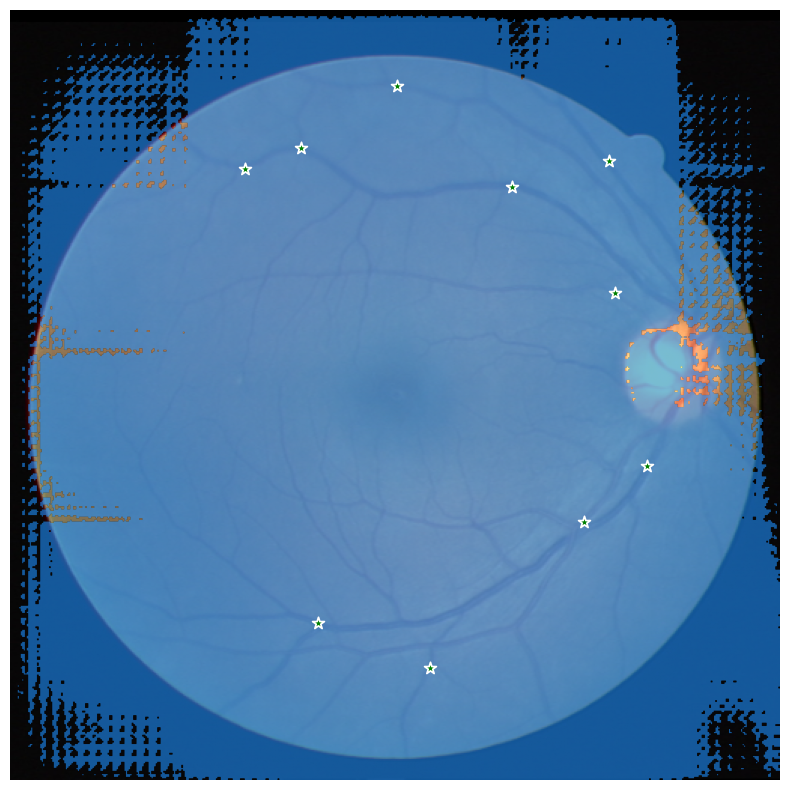

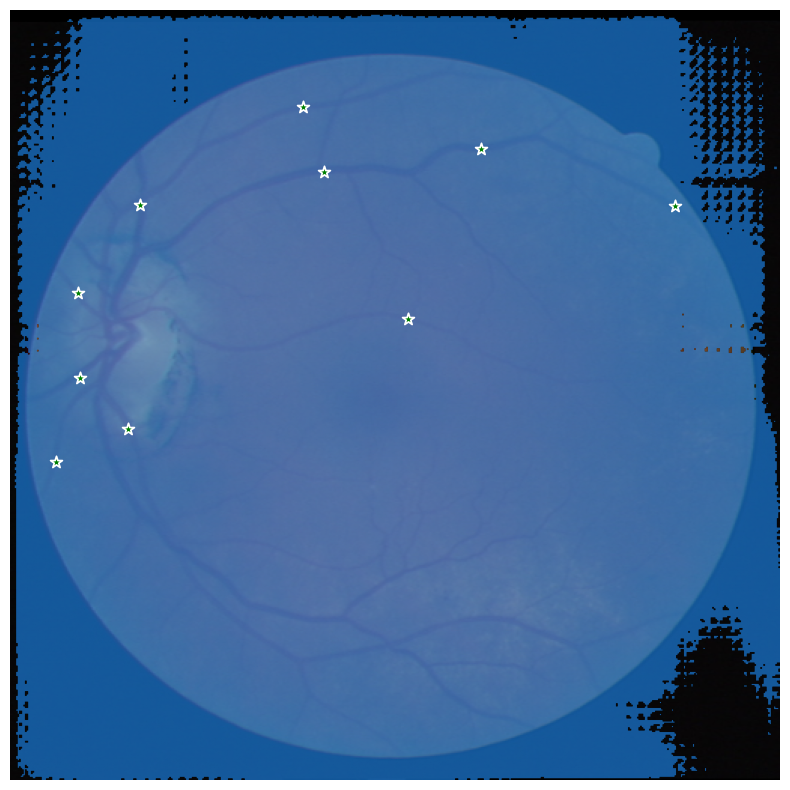

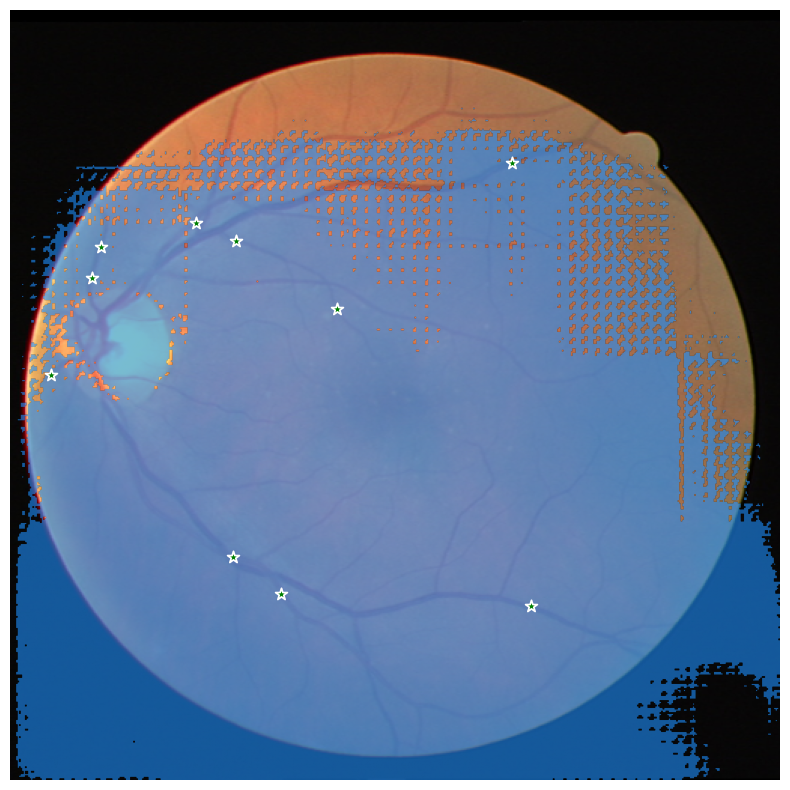

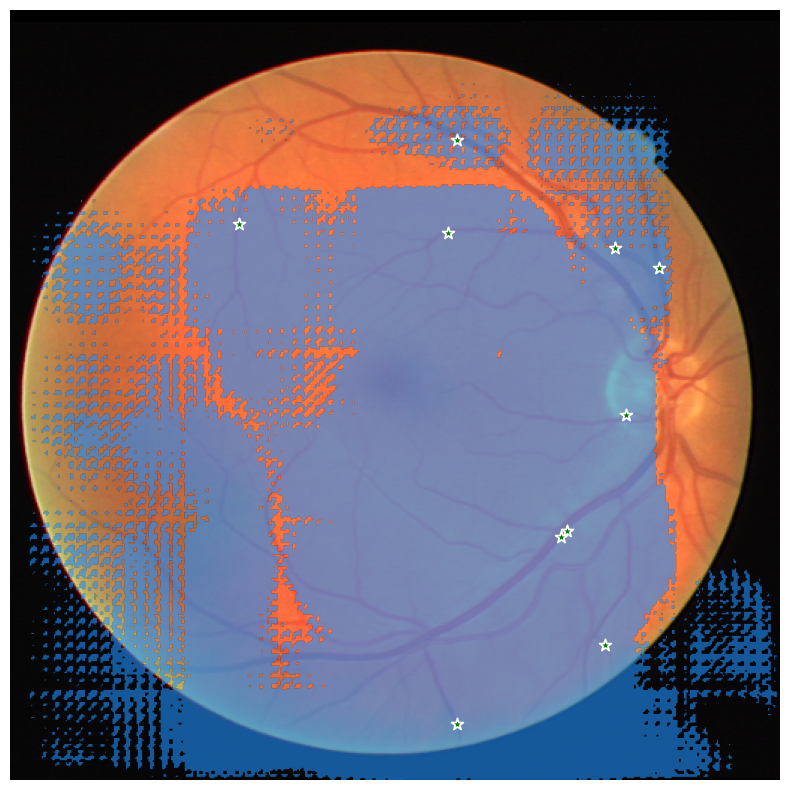

In [110]:
dice_list = []
iou_list = []
acc_list = []
specificity_list = []
sensitivity_list = []

for batch in test_loader:
    images,masks = batch
    for batch_idx in range(images.shape[0]):
        image,mask = images[batch_idx],masks[batch_idx]
        img_metric = predict_and_evaluate(image,mask)
        dice_list.append(img_metric['dice'])
        acc_list.append(img_metric['acc'])
        iou_list.append(img_metric['iou'])
        specificity_list.append(img_metric['specificity'])
        sensitivity_list.append(img_metric['sensitivity'])


In [116]:
print("Show Performance Metrics:")
print(f"Dice {np.mean(dice_list):1f}")
print(f"IOU {np.mean(iou_list):.4f}")
print(f"Acc {np.mean(acc_list):.4f}")
print(f"Specificity {np.mean(specificity_list):.4f}")
print(f"Sensitivity {np.mean(sensitivity_list):.4f}")

Show Performance Metrics:
Dice 0.168578
IOU 0.0921
Acc 0.3046
Specificity 0.2532
Sensitivity 0.8724
